Este proyecto es un sistema de recomendación de productos en desarrollo, destinado a mejorar la experiencia de compra en el e-commerce. Utiliza datos reales de transacciones de 2010 y 2011 del dataset "Online Retail" disponible en el UCI Machine Learning Repository.

Se busca crear un sistema de recomendación hibrido, que tenga en cuenta la descripción y productos que compraron usuarios similares

# Elimino los warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importamos Librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carga del archivo csv

In [3]:
# Cargar datos con encoding latin1
df = pd.read_csv('data.csv',encoding='latin1')

# Revisamos el Dataframe

En un principio observamos una tabla con 8 columnas:

InvoiceNo = El número de la factura
StockCode = El codigo del producto
Description = La descripción del producto
Quantity = La cantidad de este producto en el pedido
InvoiceDate = La fecha y hora del pedido
UnitPrice = El precio por unidad
CustomerID = El codigo de cliente
Country = El país de compra

In [4]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


Al observar la información del dataset, vemos que existen datos faltantes en CustomerID y Description, veamos cuantos

# Revision de datos faltantes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# Comprobar valores nulos
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Calculamos el porcentaje de valores nulos
df.isna().sum()/len(df)*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Tenemos un 25% de valores nulos en CustomerID, exactamente 135080 pedidos. Tenemos varias opciones:

* Imputarles un valor unico: Esto es un problema, ya que consideraríamos que hay un cliente que ha comprado todos esos productos, por lo que el sistema puede pensar que es un cliente similar a muchos otros clientes o resultar como un cliente atipico.

* Imputarles un valor unico a cada pedido: Esto provocaria un aumento de clientes que solo han pedido una vez, y podrian crear un cluster propio.

* Eliminarlos: Perderíamos el 25% del dataset

De momento sigamos analizando el dataset, luego veremos como solucionar esto.

En el dataset existe una linea por cada producto, por tanto un mismo pedido tendra varias lineas, con mismo numero de pedido y mismo numero de cliente, así que puede ser importante comparar si existen valores nulos en pedidos que tengamos valores no nulos, de esta forma sabriamos el customerID que corresponde. Al igual podemos hacerlo con la description. En caso de que un StockCode de un valor nulo exista en un StockCode de valor nulo, y de esta forma conoceriamos la descripción.


In [8]:
# Buscamos valores de description que no sean nulos para el mismo stockcode de un valor nulo de description
def check_null_and_not_null(group):
    return group.isnull().any() and group.notnull().any()

# Filtrar los StockCode que cumplen con la condición
filtered_stockcodes = df.groupby('StockCode')['Description'].filter(check_null_and_not_null)

# Obtener las filas del DataFrame original donde los StockCode cumplen con la condición
result = df[df['StockCode'].isin(filtered_stockcodes.unique())]

print(result)

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []


** NOTA **: En el segundo EDA vemos que esto está mal

Acabamos de comprobar que no existen registros, por tanto, los productos sin descripcion son los mismos, veamos cuantas veces se repite cada StockCode sin valor en description

In [9]:
# veamos cuantas veces se repite cada StockCode con description nula
# Filtrar para obtener solo las filas donde 'description' es nulo
df_null_descriptions = df[df['Description'].isnull()]

# Contar cuántas veces se repite cada StockCode
stockcode_counts = df_null_descriptions['StockCode'].value_counts()

print(stockcode_counts)

StockCode
35965     10
23084     10
22084      9
22451      6
22501      5
          ..
16169P     1
84846A     1
82545A     1
84251F     1
85175      1
Name: count, Length: 960, dtype: int64


Tenemos 960 productos sin descripción. Aunque podriamos usar su StockCode para encontrar clientes que han comprado ese producto, no podemos usar su descripcion para saber que tipo de producto es.

Finalmente decido eliminar las lineas con datos faltantes de CustomerID y Descriptions nulas, aunque es una perdida considerable, el tamaño del dataset continua siendo considerablemente grande.

In [10]:
# Eliminamos los valores nulos

# Eliminar las filas con valores nulos
df = df.dropna()

In [11]:
# Comprobamos que se han eliminado correctamente

df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


Han quedado 406829 Entradas

Ahora vamos a ver las estadisticas descriptivas del Dataset

In [13]:
# Eliminar notación cientifica
pd.options.display.float_format = '{:.6f}'.format

In [14]:
# Una primera aproximacion a las estadisticas descriptivas transponiendo la tabla

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.000000,12.061303,248.693370,-80995.000000,2.000000,5.000000,12.000000,80995.000000
UnitPrice,406829.000000,3.460471,69.315162,0.000000,1.250000,1.950000,3.750000,38970.000000
CustomerID,406829.000000,15287.690570,1713.600303,12346.000000,13953.000000,15152.000000,16791.000000,18287.000000


In [15]:
# Veamos una estadistica descriptiva de las variables categoricas

df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,406829,22190,576339,542
StockCode,406829,3684,85123A,2077
Description,406829,3896,WHITE HANGING HEART T-LIGHT HOLDER,2070
InvoiceDate,406829,20460,11/14/2011 15:27,543
Country,406829,37,United Kingdom,361878


Conclusiones:

* Cantidad: La media de productos en cada transaccion es de 9.55, va de un minimo de -80995 a un maximo de 80995, Los valores negativos indican pedidos cancelados o devueltos, esto es algo que hay que tratar adecuadamente.Existen valores atípicos ya que hay mucha diferencia entre el maximo y el valor del percentil 75, además la desviación típica es de 248, lo que indica bastante dispersion en los datos. 

* Precio por unidad: La media de precios por unidad es de 4.61, va de un valor mínimo de 0 a un máximo de 38970, lo cual es un rango bastante amplio, o bien existen datos erroneos, o se venden productos de un gran abanico de precios. También existe mucha diferencia entre el máximo y el percentil 75, por lo que existen valores atípicos. La desviación típica es de 69.31.

* Numero de factura: Hay 22190 facturas unicas, lo que quiere decir que la muestra contiene 22190 transacciones. La factura con más productos diferentes es la 576339 que aparece 542 veces.

* StockCode: Hay 3684 StockCodes unicos, por lo que en la muestra tenemos 3684 productos. El producto que aparece en más facturas es el 85123A, lo que no indica que sea el producto más vendido, sino un producto que se pide en la mayoría de pedidos.

* Descripción: Hay 3896 descripciones para 3684 productos, esto indica que existen descripciones diferentes para un mismo producto. Esto puede deberse a algun cambio en la descripcion durante el periodo cubierto por el dataset. 

* InvoiceDate: Hay 20460 fechas diferentes, habria que comprobar cuantos dias existen en el dataset. La fecha con más productos diferentes pedidos es el 14/11/2011 a las 15:27, BlackFriday fue el 25 de noviembre, habría que comprobar si esta tienda realizó black week, o si hubo algun evento especial en esta fecha.

* Country: Hay 37 paises diferentes en el dataset, el más repetido es United Kingdom con 361878 pedidos desde alli (Aproximadamente el 89% de los pedidos)


# Busqueda de duplicados

Ahora vamos a buscar si hay valores duplicados en el dataset

In [16]:
# Busqueda de duplicados marcando todas las instancias de duplicados
filas_duplicadas = df[df.duplicated(keep=False)]

# Ordenamos los datos para verlas mejor
filas_duplicadas_ordenadas = filas_duplicadas.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Mostramos las 10 primeras filas
filas_duplicadas_ordenadas.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.250000,17908.000000,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.250000,17908.000000,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.950000,17908.000000,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.950000,17908.000000,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.100000,17908.000000,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.100000,17908.000000,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.950000,17908.000000,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.950000,17908.000000,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.650000,17920.000000,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.650000,17920.000000,United Kingdom


In [17]:
count_items = df[df['InvoiceNo'] == '536409'].shape[0]
count_items

58

In [18]:
# Obtener los valores mínimo y máximo de los índices para el InvoiceNo 536409
min_index = df[df['InvoiceNo'] == '536409'].index.min()
max_index = df[df['InvoiceNo'] == '536409'].index.max()

min_index, max_index


(483, 540)

In [19]:
count_items = df[df['InvoiceNo'] == '536412'].shape[0]

# Obtener los valores mínimo y máximo de los índices para el InvoiceNo 536412
min_index = df[df['InvoiceNo'] == '536412'].index.min()
max_index = df[df['InvoiceNo'] == '536412'].index.max()

min_index, max_index, count_items

(541, 621, 81)

No tenemos muchos casos de entradas duplicadas. Aqui tenemos que hacer suposiciones:

* Opción 1: El cliente añadió al carrito el producto, a continuación añadió otros productos y luego volvió a añadir el primero. La hora del pedido es la misma para ambos productos, por lo que es normal que sea la misma.

* Opcion 2: Es un error, del dataset y tendriamos que eliminar el duplicado.

Como son pocos, podemos analizarlo tranquilamente. Si observamos, se producen varios duplicados en el mismo pedido. Es un pedido con 58 articulos, que van del indice 483 al 540, todos los productos del pedido se encuentran en ese rango, asi que pueden ser perfectamente productos que el usuario ha añadido de forma separada.

El segundo pedido con 1 solo articulo duplicado tiene 81 articulos, que van del 541 al 621.

Habria que comprobar si la plataforma al generar la factura, en caso de meter los productos por separados, no los acumula sino que los añade en lineas diferentes, auque resulta extraño que sea un caso que solo le suceda a dos clientes, 1 sola vez y con tanta cantidad de articulos en la factura, asi que he decidido eliminar los duplicados.

In [20]:
# Removing duplicate rows
df.drop_duplicates(inplace=True)

In [21]:
# Vemos cuantas entradas han quedado
df.shape[0]

401604

Quedan 401604 entradas

Vamos a buscar valores de precios extraños

In [22]:
# Ver UnitPrice menores a 1
df[df['UnitPrice'] < 0.01].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.000000,12647.000000,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.000000,16560.000000,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.000000,14911.000000,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.000000,13081.000000,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.000000,13081.000000,United Kingdom


In [23]:
df[df['UnitPrice'] < 0.01].count()

InvoiceNo      44
StockCode      44
Description    44
Quantity       44
InvoiceDate    44
UnitPrice      44
CustomerID     44
Country        44
dtype: int64

Vemos que hay 44 productos con un precio menor a 0.01, lo que podríamos considerar como precio 0, así que vamos a eliminar estas entradas para mantener un dataset limpio

In [24]:
# Borramos las entradas con UnitPrice menores a 0.01

df = df[df['UnitPrice'] >= 0.01]

Busquemos ahora productos con precios excesivamente altos, vamos a ver la descripción y a entender si tienen sentido o son un error

In [25]:
df[df['UnitPrice'] > 100.00].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
246,536392,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,12/1/2010 10:29,165.000000,13705.000000,United Kingdom
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,12/2/2010 18:06,295.000000,13145.000000,United Kingdom
14498,C537597,D,Discount,-1,12/7/2010 12:34,281.000000,15498.000000,United Kingdom
19392,C537857,D,Discount,-1,12/8/2010 16:00,267.120000,17340.000000,United Kingdom
19428,537859,22828,REGENCY MIRROR WITH SHUTTERS,1,12/8/2010 16:11,165.000000,14030.000000,United Kingdom


Con esta comprobación, viendo los 5 primeros, no hemos encontrado el producto que tenia un precio excesivamente alto, pero descubrimos que existen productos con la descripcion Discount, StockCode D, y cantidad -1, es decir, una devolucion. Tenemos que ver como tratar esto.

In [26]:
df[df['UnitPrice'] > 1000.00].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45622,C540271,M,Manual,-1,1/6/2011 11:51,1126.000000,12503.000000,Spain
73446,C542348,M,Manual,-1,1/27/2011 12:09,1715.850000,12539.000000,Spain
117052,C546325,M,Manual,-1,3/11/2011 10:15,1687.170000,14911.000000,EIRE
117053,C546327,M,Manual,-1,3/11/2011 10:18,1687.170000,14911.000000,EIRE
117054,546328,M,Manual,1,3/11/2011 10:19,1687.170000,14911.000000,EIRE


Al aumentar la busqueda a mayores de 1000€ encontramos una descripción "Manual, con StockCode M, y precios mayores de 1000 u.m, muchas son cancelaciones, pero hay 1 que no lo es. Además, vemos que las cancelaciones tienen el InvoiceNo con una C. Sigamos aumentando el filtro

In [27]:
df[df['UnitPrice'] > 2000.00].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
144826,548813,M,Manual,1,4/4/2011 13:03,2382.920000,12744.000000,Singapore
144829,548820,M,Manual,1,4/4/2011 13:04,2053.070000,12744.000000,Singapore
144831,C548830,M,Manual,-1,4/4/2011 13:08,2382.920000,12744.000000,Singapore
144834,C548834,M,Manual,-1,4/4/2011 13:09,2053.070000,12744.000000,Singapore
173277,C551685,POST,POSTAGE,-1,5/3/2011 12:51,8142.750000,16029.000000,United Kingdom


Al aumentar a mas de 2000 seguimos viendo la descripcion Manual, pero aparece una nueva descripcion. Postage con StockCode Post. En este caso una cancelacion pero por un precio de 8142. Tenemos que ver más de cerca estas categorías.

In [28]:
df[df['UnitPrice'] > 3000.00].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173277,C551685,POST,POSTAGE,-1,5/3/2011 12:51,8142.750000,16029.000000,United Kingdom
173382,551697,POST,POSTAGE,1,5/3/2011 13:46,8142.750000,16029.000000,United Kingdom
173391,C551699,M,Manual,-1,5/3/2011 14:12,6930.000000,16029.000000,United Kingdom
222681,C556445,M,Manual,-1,6/10/2011 15:31,38970.000000,15098.000000,United Kingdom
268027,C560372,M,Manual,-1,7/18/2011 12:26,4287.630000,17448.000000,United Kingdom


Aquí observamos que ya aparece el "producto" de 38970, una cancelacion de "M" Manual. Esta M tendriamos que consultar que quiere decir, posiblemente sean referencias introducidas manualmente. Vamos a comprobar que StockCodes existen que no sean un valor numerico.

In [29]:
# 1. StockCodes que empiezan por letra y mostrar los valores únicos
stockcodes_empiezan_con_letra = df[df['StockCode'].str.match(r'^[A-Za-z]')]['StockCode'].unique()

# 2. StockCodes que contienen solo letras y mostrar los valores únicos
stockcodes_solo_letras = df[df['StockCode'].str.isalpha()]['StockCode'].unique()

# 3. StockCodes que tienen menos de 6 dígitos y mostrar los valores únicos
stockcodes_menos_de_5_digitos = df[df['StockCode'].str.len() < 5]['StockCode'].unique()

# Mostrar los resultados
print("StockCodes que empiezan con letra:", stockcodes_empiezan_con_letra)
print("StockCodes que contienen solo letras:", stockcodes_solo_letras)
print("StockCodes con menos de 5 dígitos:", stockcodes_menos_de_5_digitos)

StockCodes que empiezan con letra: ['POST' 'D' 'C2' 'M' 'BANK CHARGES' 'DOT' 'CRUK']
StockCodes que contienen solo letras: ['POST' 'D' 'M' 'DOT' 'CRUK']
StockCodes con menos de 5 dígitos: ['POST' 'D' 'C2' 'M' 'DOT' 'CRUK']


In [30]:
df[df['StockCode'] == 'CRUK']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
317508,C564763,CRUK,CRUK Commission,-1,8/30/2011 10:49,1.600000,14096.000000,United Kingdom
324023,C565382,CRUK,CRUK Commission,-1,9/2/2011 15:45,13.010000,14096.000000,United Kingdom
333779,C566216,CRUK,CRUK Commission,-1,9/9/2011 15:17,15.960000,14096.000000,United Kingdom
338848,C566565,CRUK,CRUK Commission,-1,9/13/2011 12:32,52.240000,14096.000000,United Kingdom
351003,C567655,CRUK,CRUK Commission,-1,9/21/2011 14:40,608.660000,14096.000000,United Kingdom
361603,C568345,CRUK,CRUK Commission,-1,9/26/2011 15:28,447.560000,14096.000000,United Kingdom
372785,C569245,CRUK,CRUK Commission,-1,10/3/2011 9:57,361.590000,14096.000000,United Kingdom
390002,C570487,CRUK,CRUK Commission,-1,10/10/2011 17:12,411.920000,14096.000000,United Kingdom
401767,C571440,CRUK,CRUK Commission,-1,10/17/2011 13:31,495.980000,14096.000000,United Kingdom
416464,C572551,CRUK,CRUK Commission,-1,10/24/2011 17:07,425.140000,14096.000000,United Kingdom


Vemos que existen varias entradas que no podemos considerar como productos, aunque podemos sacar insights muy interesantes de aqui. En un caso real tendríamos que preguntar al cliente el significado de estos StockCodes, pero haremos la suposición basandonos en la descripción.

POST = Gastos de envío, parece que a paises de Europa, el precio parece variar entre 15 y 18
D = Descuento
C2 = Gastos de envío, parece que a paises de fuera de Europa, aunque aparece un envío a UK con esta descripción. Parece que el precio de carriage siempre es 50
M = Manual, parecen cargos añadidos de forma manual que no corresponden a un producto. En principio solo se ven a UK pero hay que indagar en ello.
D = Dotcom Postage, suelen ser costos específicos de envío de pedidos en línea, para diferenciar entre pedidos fisicos o en linea. Pero habria que preguntarlo.
CRUK = CRUK Commission. Probablemente se refiere a una comisión o tarifa asociada con Cancer Research UK (CRUK), una organización benéfica líder en el Reino Unido dedicada a la investigación del cáncer. Es posible que la web pregunte al usuario si quiere colaborar con un porcentaje de la factura, y estos sean los cargos. Curiosamente se ven cantidades negativas, habria que indagar si esto es lo normal, o hay facturas con cantidades positivas de CRUK.

De momento con esto sacamos una conclusión. Necesitamos separar estas referencias de los productos para que el sistema de recomendación funcione correctamente, pero estos datos pueden ser muy utiles para relacionar patrones de clientes, por lo que crearemos columnas específicas para ellos. 


Tras realizar varias pruebas comprobando si se clasificaban todas las entradas, dejo el codigo final aqui. En estas pruebas descubrimos que existe otra descripcion llamada Bank Charges y que hay DotCom Postage llamadas DOT y no solo "D"

In [31]:
# Funcion de clasificacion

def clasificar_stockcode(stockcode):
    if stockcode == 'POST':
        return 'POST'
    elif stockcode == 'D' or stockcode == 'DOT':
        return 'DOT'
    elif stockcode == 'C2':
        return 'CARRIAGE'
    elif stockcode == 'M':
        return 'MANUAL'
    elif stockcode == 'CRUK':
        return 'CRUK'
    elif stockcode == 'BANK CHARGES':
        return 'BANK'
    elif stockcode.isdigit() or (len(stockcode) > 1 and any(char.isdigit() for char in stockcode) and any(char.isalpha() for char in stockcode)):
        return 'ORDER'
    else:
        return 'Other'

# Aplicando la función a la columna StockCode para crear una nueva columna
df['tipo'] = df['StockCode'].apply(clasificar_stockcode)



In [32]:
# Comprobar cuantas entradas hay con tipo == 'Other'

df[df['tipo'] == 'other']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tipo


In [33]:
# Vamos a marcar los cancelados y los no cancelados

df['Status'] = df['InvoiceNo'].apply(lambda x: 'CANCEL' if str(x).startswith('C') else 'COMPLETED')

Finalmente hemos categorizado todas las entradas, con esta columna podemos sacar más insights, incluso utilizarla para buscar patrones entre los clientes:

* ¿Quienes cancelan mas pedidos?
* ¿Existen errores en las cancelaciones? (Que no sean de clientes por ejemplo)
* ¿De que paises vienen unos gastos de envios u otros?, ¿afecta el volumen?
* ¿Los cargos manuales vienen siempre de los mismos clientes?
* ¿En que pedidos hay Bank Charges? ¿Tiene que ver el metodo de pago? ¿Es siempre la misma comision?
* ¿Los CRUK son siempre devoluciones?¿Hay patrones entre aquellos clientes que usan CRUK?
* Habria que señalar de alguna manera aquellos pedidos que hayan sido cancelados, por un lado, no tenerlos en cuenta como compras, por otro lado ver patrones entre clientes o productos asociados a cancelaciones.

In [34]:
# Vamos a ver cuantos pedidos quedan que sean realmente ordenes

df[df['tipo'] == 'ORDER'].count()

InvoiceNo      399656
StockCode      399656
Description    399656
Quantity       399656
InvoiceDate    399656
UnitPrice      399656
CustomerID     399656
Country        399656
tipo           399656
Status         399656
dtype: int64

Quedan 300656 pedidos, hay que tener en cuenta que muchos de estos estan cancelados, veamos cuantos

In [35]:
# Contando cuántas órdenes son canceladas y de tipo 'ORDER'
df[(df['Status'] == 'CANCEL') & (df['tipo'] == 'ORDER')].count()


InvoiceNo      8506
StockCode      8506
Description    8506
Quantity       8506
InvoiceDate    8506
UnitPrice      8506
CustomerID     8506
Country        8506
tipo           8506
Status         8506
dtype: int64

8.506 pedidos son cancelados

In [36]:
# Contando cuántas órdenes son canceladas y no son de tipo 'ORDER'
df[(df['Status'] == 'CANCEL') & (df['tipo'] != 'ORDER')].count()

InvoiceNo      366
StockCode      366
Description    366
Quantity       366
InvoiceDate    366
UnitPrice      366
CustomerID     366
Country        366
tipo           366
Status         366
dtype: int64

366 entradas de cancelaciones son una referencia especial.

Vamos a comprobar si el valor del invoice es el mismo que el del cancelado, pero con la C, o son números diferentes

In [37]:
print (df[(df['InvoiceNo'] == '536383')].count())
print (df[(df['InvoiceNo'] == 'C536383')].count())


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
tipo           0
Status         0
dtype: int64
InvoiceNo      1
StockCode      1
Description    1
Quantity       1
InvoiceDate    1
UnitPrice      1
CustomerID     1
Country        1
tipo           1
Status         1
dtype: int64


Vemos que son numeros diferentes, así que entendemos que aquellos con C son pedidos cancelados y el resto pedidos completados

In [38]:
# Cantidad de ordenes Completed y Canceladas
df['Status'].value_counts()

Status
COMPLETED    392688
CANCEL         8872
Name: count, dtype: int64

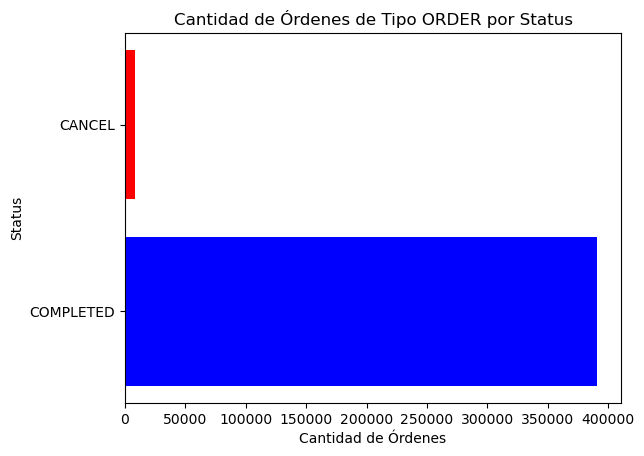

In [39]:
# Filtrar para obtener solo las órdenes de tipo 'ORDER'
ordenes_order = df[df['tipo'] == 'ORDER']

# Contar las órdenes 'COMPLETED' y 'CANCEL'
orden_completed = ordenes_order[ordenes_order['Status'] == 'COMPLETED'].shape[0]
orden_cancel = ordenes_order[ordenes_order['Status'] == 'CANCEL'].shape[0]

# Datos para el gráfico
status = ['COMPLETED', 'CANCEL']
counts = [orden_completed, orden_cancel]

# Crear el gráfico de barras horizontales
plt.barh(status, counts, color=['blue', 'red'])
plt.xlabel('Cantidad de Órdenes')
plt.ylabel('Status')
plt.title('Cantidad de Órdenes de Tipo ORDER por Status')
plt.show()

Vemos que la tasa de pedidos cancelados es muy baja, pero son un dato interesante para tener en cuenta los productos con riesgo de cancelacion

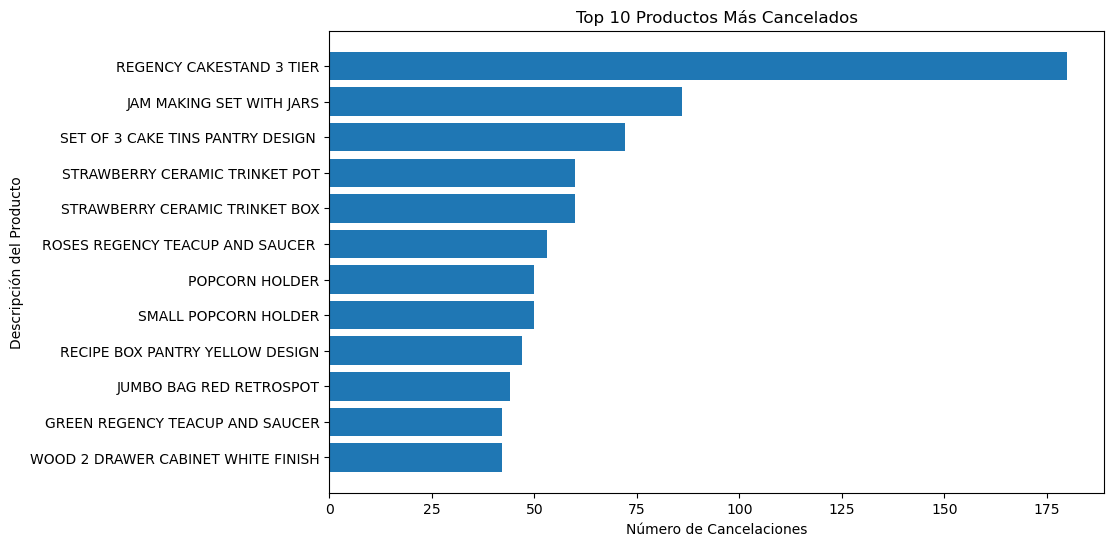

In [40]:
# Filtrar para obtener solo las órdenes 'CANCEL'
ordenes_cancel = df[(df['Status'] == 'CANCEL') & (df['tipo'] == 'ORDER')]


# Contar cuántas veces se repite cada StockCode
stockcode_counts = ordenes_cancel['StockCode'].value_counts().head(10)

# Obtener las descripciones para los StockCodes más cancelados
top_cancelados = df[df['StockCode'].isin(stockcode_counts.index)][['StockCode', 'Description']].drop_duplicates()

# Crear un DataFrame para el gráfico
df_grafico = pd.DataFrame({
    'StockCode': stockcode_counts.index,
    'Counts': stockcode_counts.values
})

# Unir las descripciones con las cuentas
df_grafico = df_grafico.merge(top_cancelados, on='StockCode')

# Ordenar por Counts para el gráfico
df_grafico.sort_values('Counts', ascending=True, inplace=True)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df_grafico['Description'], df_grafico['Counts'])
plt.xlabel('Número de Cancelaciones')
plt.ylabel('Descripción del Producto')
plt.title('Top 10 Productos Más Cancelados')
plt.show()



Podemos observar que REGENCY CAKESTAND 3 TIER es el producto más cancelado con mucha diferencia, más de 175 cancelaciones
Veamos el top 10 productos que más aparecen en el Dataset

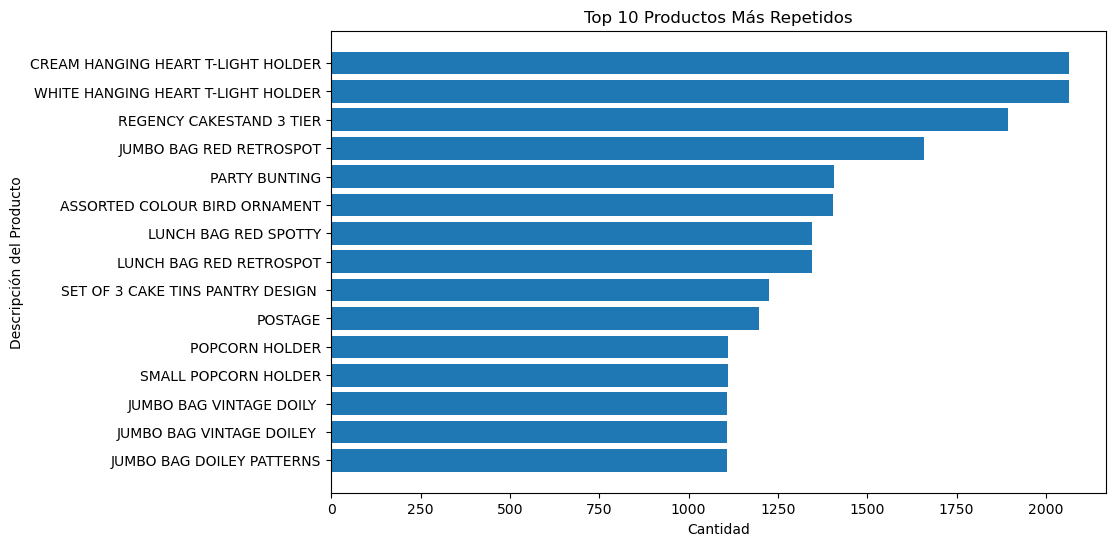

In [41]:
# Contar cuántas veces se repite cada StockCode
stockcode_counts = df['StockCode'].value_counts().head(10)

# Obtener las descripciones para los StockCodes más repetidos
top_repetidos = df[df['StockCode'].isin(stockcode_counts.index)][['StockCode', 'Description']].drop_duplicates()

# Crear un DataFrame para el gráfico
df_grafico = pd.DataFrame({
    'StockCode': stockcode_counts.index,
    'Counts': stockcode_counts.values
})

# Unir las descripciones con las cuentas
df_grafico = df_grafico.merge(top_repetidos, on='StockCode')

# Ordenar por Counts para el gráfico
df_grafico.sort_values('Counts', ascending=True, inplace=True)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df_grafico['Description'], df_grafico['Counts'])
plt.xlabel('Cantidad')
plt.ylabel('Descripción del Producto')
plt.title('Top 10 Productos Más Repetidos')
plt.show()

Aqui podemos ver que REGENCY CAKESTAND 3 TIER es el tercer producto más vendido. Una nueva columna que podemos añadir es el ratio de cancelacion, pero para hacer esto correctamente y comprobar las cantidades correctamente deberemos usar la columna quantity.

In [42]:
# Crear columna con el total de veces que se ha comprado cada producto, para ello usaremos la columna Quantity, y solo usaremos Status Completed

# Primero, filtramos el DataFrame para quedarnos solo con las filas donde Status es 'COMPLETED'
df_completed = df[df['Status'] == 'COMPLETED']

# Luego, agrupamos por 'StockCode' y sumamos 'Quantity'
quantity_sum = df_completed.groupby('StockCode')['Quantity'].sum()

# Ahora, creamos un nuevo DataFrame para unirlo con el original
quantity_sum_df = quantity_sum.reset_index()
quantity_sum_df.columns = ['StockCode', 'TotalSales']

# Finalmente, unimos este DataFrame con el original
df = pd.merge(df, quantity_sum_df, on='StockCode', how='left')


In [43]:
# Ahora haremos lo mismo para las cancelaciones

# Primero, filtramos el DataFrame para quedarnos solo con las filas donde Status es 'CANCEL'
df_cancel = df[df['Status'] == 'CANCEL']

# Luego, agrupamos por 'StockCode' y sumamos 'Quantity'
quantity_sum = df_cancel.groupby('StockCode')['Quantity'].sum().abs()

# Ahora, creamos un nuevo DataFrame para unirlo con el original
quantity_sum_df = quantity_sum.reset_index()
quantity_sum_df.columns = ['StockCode', 'TotalCancel']

# Finalmente, unimos este DataFrame con el original
df = pd.merge(df, quantity_sum_df, on='StockCode', how='left')


In [44]:
# Ahora vamos a crear una columna que indique la tasa de cancelaciones (Cancel / (Sales + Cancel))

df['TasaCancel'] = (df['TotalCancel'] / (df['TotalSales'] + df['TotalCancel']))*100

In [45]:
status_cancelled = 'CANCEL'

# Filtramos el DataFrame para quedarnos solo con las filas donde Status es 'CANCELLED'
df_cancelled = df[df['Status'] == status_cancelled]

# Agrupamos por 'CustomerID' y 'StockCode' y contamos las ocurrencias
cancelled_counts = df_cancelled.groupby(['CustomerID', 'StockCode']).size().reset_index(name='CancelledCount')

# Unimos este nuevo DataFrame con el DataFrame original
df = pd.merge(df, cancelled_counts, on=['CustomerID', 'StockCode'], how='left')

# Rellenamos los NaN con 0, ya que si no hay registro de cancelación, el conteo debería ser 0
df['CancelledCount'].fillna(0, inplace=True)

# Convertimos 'CancelledCount' a tipo entero, ya que no puede haber una cantidad fraccionada de cancelaciones
df['CancelledCount'] = df['CancelledCount'].astype(int)


In [46]:
# Ahora haremos lo mismo para contar las veces que el cliente ha completado un pedido con ese producto

status_completed = 'COMPLETED'

# Filtramos el DataFrame para quedarnos solo con las filas donde Status es 'COMPLETED'
df_completed = df[df['Status'] == status_completed]

# Agrupamos por 'CustomerID' y 'StockCode' y contamos las ocurrencias
completed_counts = df_completed.groupby(['CustomerID', 'StockCode']).size().reset_index(name='CompletedCount')

# Unimos este nuevo DataFrame con el DataFrame original
df = pd.merge(df, completed_counts, on=['CustomerID', 'StockCode'], how='left')

# Rellenamos los NaN con 0, ya que si no hay registro de completado, el conteo debería ser 0
df['CompletedCount'].fillna(0, inplace=True)

# Convertimos 'CompletedCount' a tipo entero, ya que no puede haber una cantidad fraccionada de completados
df['CompletedCount'] = df['CompletedCount'].astype(int)



In [47]:
# Ahora vamos a crear una columna que indique la tasa de cancelaciones (CancelledCount / (CompletedCount + CancelledCount) del cliente)

df['TasaCancelCliente'] = (df['CancelledCount'] / (df['CompletedCount'] + df['CancelledCount']))*100


In [48]:
# Comprobamos los 10 primeros registros con CancelledCount > 0

df[df['CompletedCount'] > 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tipo,Status,TotalSales,TotalCancel,TasaCancel,CancelledCount,CompletedCount,TasaCancelCliente
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.550000,17850.000000,United Kingdom,ORDER,COMPLETED,36763.000000,2578.000000,6.552960,0,17,0.000000
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.390000,17850.000000,United Kingdom,ORDER,COMPLETED,1633.000000,39.000000,2.332536,0,17,0.000000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.750000,17850.000000,United Kingdom,ORDER,COMPLETED,1917.000000,42.000000,2.143951,0,15,0.000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.390000,17850.000000,United Kingdom,ORDER,COMPLETED,2465.000000,14.000000,0.564744,0,17,0.000000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.390000,17850.000000,United Kingdom,ORDER,COMPLETED,3676.000000,19.000000,0.514208,0,17,0.000000
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.650000,17850.000000,United Kingdom,ORDER,COMPLETED,1651.000000,124.000000,6.985915,0,16,0.000000
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.250000,17850.000000,United Kingdom,ORDER,COMPLETED,497.000000,14.000000,2.739726,2,17,10.526316
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.850000,17850.000000,United Kingdom,ORDER,COMPLETED,4730.000000,26.000000,0.546678,0,17,0.000000
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.850000,17850.000000,United Kingdom,ORDER,COMPLETED,4388.000000,17.000000,0.385925,1,17,5.555556
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.690000,13047.000000,United Kingdom,ORDER,COMPLETED,35263.000000,48.000000,0.135935,0,1,0.000000


Bien, ya tenemos las tasas de cancelacion por producto y por producto y cliente. Ahora vamos a crear una columna para calcular el importe total pagado por cliente y el importe de cancelaciones total de cada cliente

In [49]:
# Calculamos Precio Total (tomando el valor absoluto de Quantity para las cancelaciones)
df['Precio Total'] = df['Quantity'].abs() * df['UnitPrice']

# Para Compras Totales, filtramos por Status COMPLETED y agrupamos por CustomerID
compras_totales = df[df['Status'] == 'COMPLETED'].groupby('CustomerID')['Precio Total'].sum().reset_index()
compras_totales.columns = ['CustomerID', 'Compras Totales']

# Unimos esta información con el DataFrame original
df = pd.merge(df, compras_totales, on='CustomerID', how='left')

# Para Cancelaciones Totales, filtramos por Status CANCEL y agrupamos por CustomerID
cancelaciones_totales = df[df['Status'] == 'CANCEL'].groupby('CustomerID')['Precio Total'].sum().reset_index()
cancelaciones_totales.columns = ['CustomerID', 'Cancelaciones Totales']

# Unimos esta información con el DataFrame original
df = pd.merge(df, cancelaciones_totales, on='CustomerID', how='left')

# Rellenamos los NaN con 0 en las columnas de totales
df[['Compras Totales', 'Cancelaciones Totales']] = df[['Compras Totales', 'Cancelaciones Totales']].fillna(0)


In [50]:
df['tipo'].unique()

array(['ORDER', 'POST', 'DOT', 'CARRIAGE', 'MANUAL', 'BANK', 'CRUK'],
      dtype=object)

Vamos a ver si cada tipo tiene alguna relación con los paises

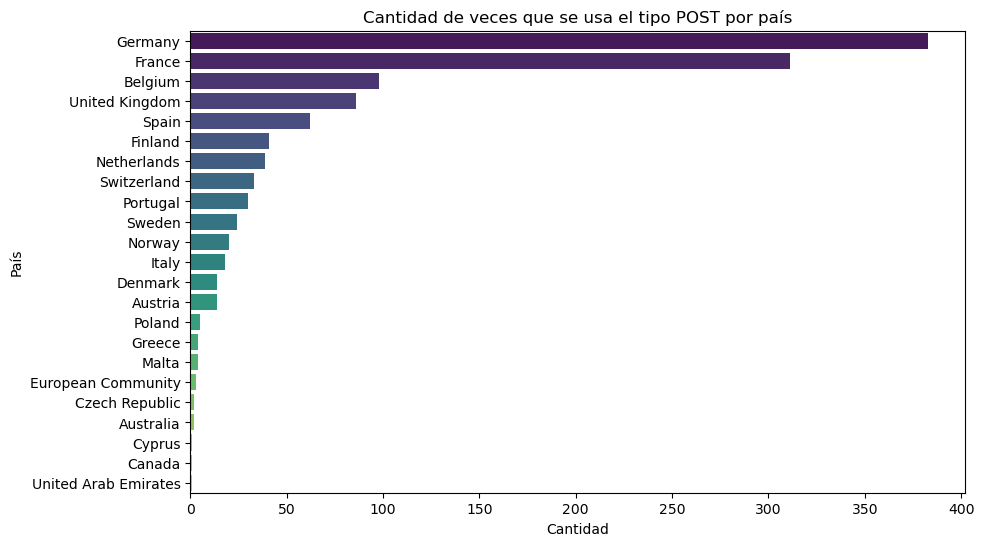

In [51]:
# Contar veces que se usa el tipo POST por pais

# Filtramos el DataFrame para quedarnos solo con las filas
# donde el tipo es 'POST' y agrupamos por 'Country'

manual_counts = df[df['tipo'] == 'POST'].groupby('Country').size().reset_index(name='ManualCount')

# Ordenamos por 'ManualCount' para el gráfico
manual_counts.sort_values('ManualCount', ascending=False, inplace=True)

# Creamos el gráfico de barras
plt.figure(figsize=(10, 6))

sns.barplot(data=manual_counts, x='ManualCount', y='Country', palette='viridis')
plt.xlabel('Cantidad')
plt.ylabel('País')
plt.title('Cantidad de veces que se usa el tipo POST por país')
plt.show()

Vemos que Alemania es el país con mas cargos por POST, seguido de Francia, Belgica, UK, España...

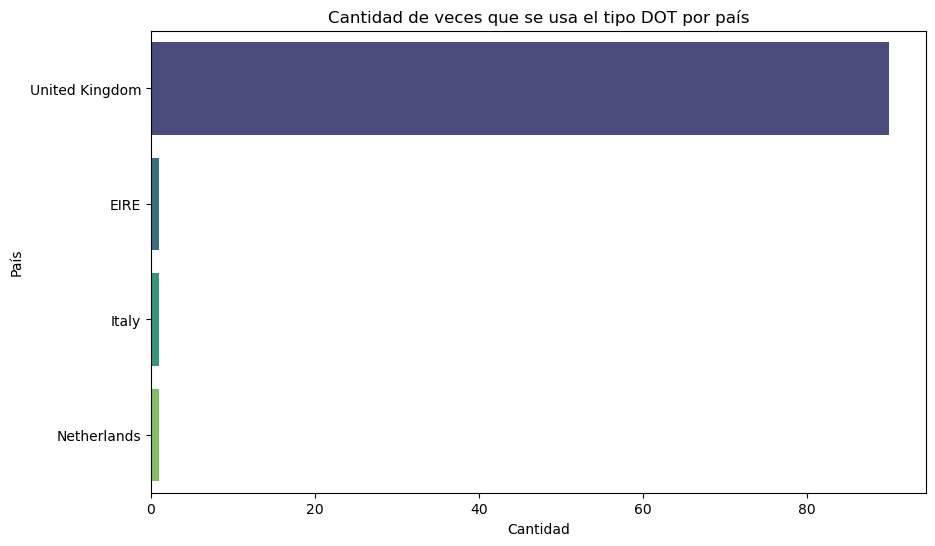

In [52]:
# Contar veces que se usa el tipo DOT por pais

# Filtramos el DataFrame para quedarnos solo con las filas
# donde el tipo es 'DOT' y agrupamos por 'Country'

manual_counts = df[df['tipo'] == 'DOT'].groupby('Country').size().reset_index(name='ManualCount')

# Ordenamos por 'ManualCount' para el gráfico
manual_counts.sort_values('ManualCount', ascending=False, inplace=True)

# Creamos el gráfico de barras
plt.figure(figsize=(10, 6))

sns.barplot(data=manual_counts, x='ManualCount', y='Country', palette='viridis')
plt.xlabel('Cantidad')
plt.ylabel('País')
plt.title('Cantidad de veces que se usa el tipo DOT por país')
plt.show()

Los DOT vienen principalmente de UK

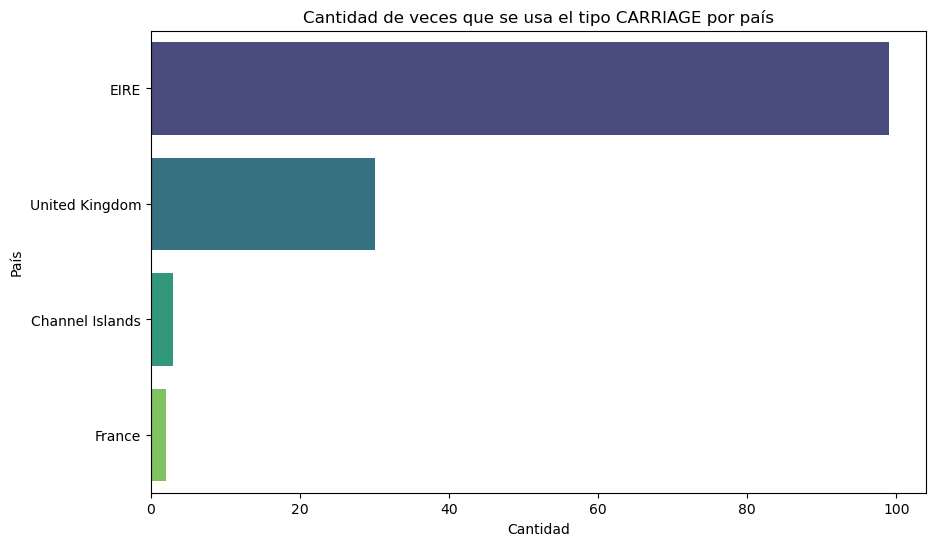

In [53]:
# Contar veces que se usa el tipo CARRIAGE por pais

# Filtramos el DataFrame para quedarnos solo con las filas
# donde el tipo es 'CARRIAGE' y agrupamos por 'Country'

manual_counts = df[df['tipo'] == 'CARRIAGE'].groupby('Country').size().reset_index(name='ManualCount')

# Ordenamos por 'ManualCount' para el gráfico
manual_counts.sort_values('ManualCount', ascending=False, inplace=True)

# Creamos el gráfico de barras
plt.figure(figsize=(10, 6))

sns.barplot(data=manual_counts, x='ManualCount', y='Country', palette='viridis')
plt.xlabel('Cantidad')
plt.ylabel('País')
plt.title('Cantidad de veces que se usa el tipo CARRIAGE por país')
plt.show()

Sin embargo la mayoría de Carriage es con pedidos de EIRE (Irlanda)

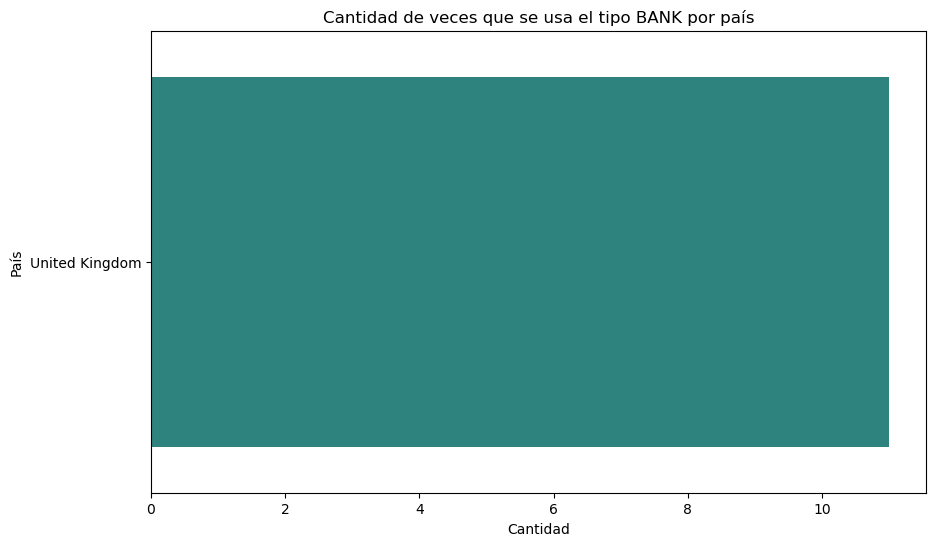

In [54]:
# Contar veces que se usa el tipo BANK por pais

# Filtramos el DataFrame para quedarnos solo con las filas
# donde el tipo es 'BANK' y agrupamos por 'Country'

manual_counts = df[df['tipo'] == 'BANK'].groupby('Country').size().reset_index(name='ManualCount')

# Ordenamos por 'ManualCount' para el gráfico
manual_counts.sort_values('ManualCount', ascending=False, inplace=True)

# Creamos el gráfico de barras
plt.figure(figsize=(10, 6))

sns.barplot(data=manual_counts, x='ManualCount', y='Country', palette='viridis')
plt.xlabel('Cantidad')
plt.ylabel('País')
plt.title('Cantidad de veces que se usa el tipo BANK por país')
plt.show()

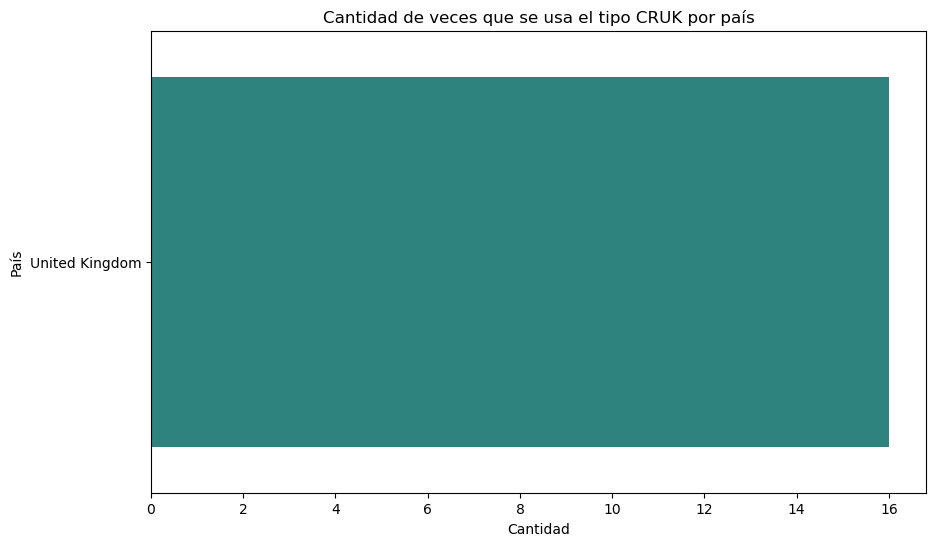

In [55]:
# Contar veces que se usa el tipo CRUK por pais

# Filtramos el DataFrame para quedarnos solo con las filas
# donde el tipo es 'CRUK' y agrupamos por 'Country'

manual_counts = df[df['tipo'] == 'CRUK'].groupby('Country').size().reset_index(name='ManualCount')

# Ordenamos por 'ManualCount' para el gráfico
manual_counts.sort_values('ManualCount', ascending=False, inplace=True)

# Creamos el gráfico de barras
plt.figure(figsize=(10, 6))

sns.barplot(data=manual_counts, x='ManualCount', y='Country', palette='viridis')
plt.xlabel('Cantidad')
plt.ylabel('País')
plt.title('Cantidad de veces que se usa el tipo CRUK por país')
plt.show()

Bank sin embargo solo viene de UK al igual que CRUK.
Analicemos ahora los productos en mayor profundidad

In [56]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'tipo', 'Status', 'TotalSales',
       'TotalCancel', 'TasaCancel', 'CancelledCount', 'CompletedCount',
       'TasaCancelCliente', 'Precio Total', 'Compras Totales',
       'Cancelaciones Totales'],
      dtype='object')

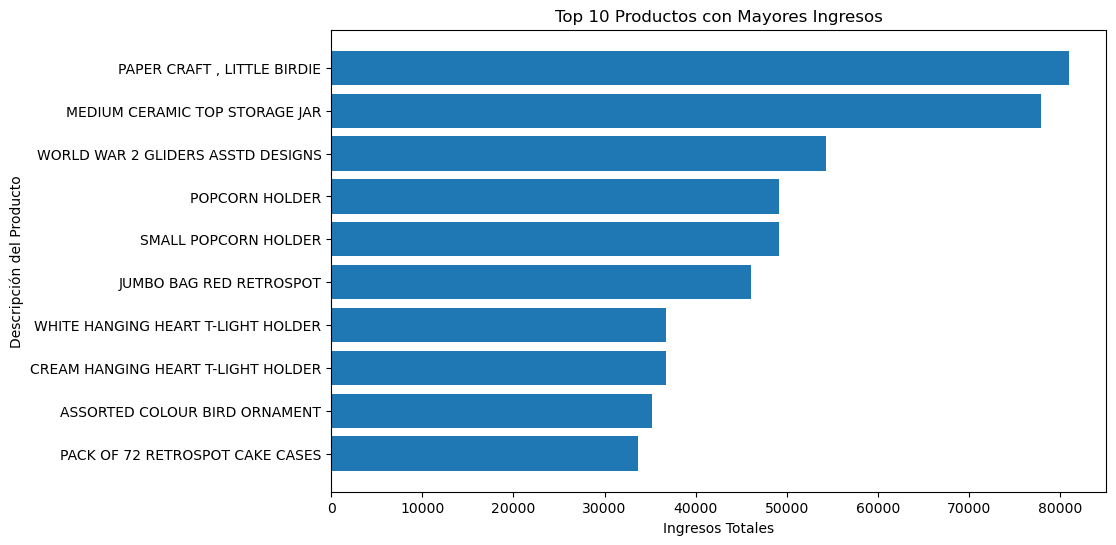

In [65]:
# Agrupamos por 'StockCode' y 'Description', y sumamos 'TotalSales'
grouped_data = df.groupby(['StockCode', 'Description'])['TotalSales'].mean().reset_index()

# Ordenamos los datos y seleccionamos el top 10
top_10_products = grouped_data.sort_values(by='TotalSales', ascending=False).head(10)

# Creamos el gráfico
plt.figure(figsize=(10, 6))
plt.barh(top_10_products['Description'], top_10_products['TotalSales'])
plt.xlabel('Ingresos Totales')
plt.ylabel('Descripción del Producto')
plt.title('Top 10 Productos con Mayores Ingresos')
plt.gca().invert_yaxis()  # Invertimos el eje y para que el producto con más ingresos esté arriba
plt.show()

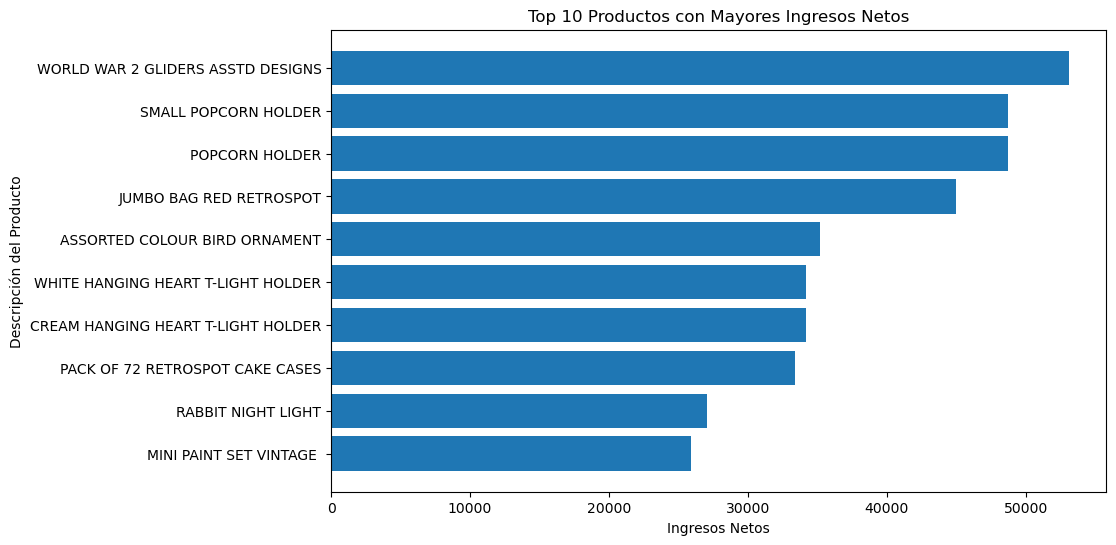

In [66]:
# Calculamos los ingresos netos (TotalSales - TotalCancel) por cada StockCode y Description
df['NetIncome'] = df['TotalSales'] - df['TotalCancel']
grouped_data = df.groupby(['StockCode', 'Description'])['NetIncome'].mean().reset_index()

# Ordenamos los datos y seleccionamos el top 10
top_10_products = grouped_data.sort_values(by='NetIncome', ascending=False).head(10)

# Creamos el gráfico
plt.figure(figsize=(10, 6))
plt.barh(top_10_products['Description'], top_10_products['NetIncome'])
plt.xlabel('Ingresos Netos')
plt.ylabel('Descripción del Producto')
plt.title('Top 10 Productos con Mayores Ingresos Netos')
plt.gca().invert_yaxis()  # Invertimos el eje y para que el producto con más ingresos esté arriba
plt.show()

Podemos observar que al tener en cuenta ingresos netos, los dos productos con mayores ingresos no aparecen. Es curioso, ya que ambos tienen el doble de ingresos que World War 2. Esto puede deberse a un error, bien en la venta o bien en la cancelacion. Asi que vamos a comprobar que ha ocurrido.

In [68]:
df[df['Description'] == 'PAPER CRAFT , LITTLE BIRDIE']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tipo,Status,TotalSales,TotalCancel,TasaCancel,CancelledCount,CompletedCount,TasaCancelCliente,Precio Total,Compras Totales,Cancelaciones Totales,NetIncome
401087,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.080000,16446.000000,United Kingdom,ORDER,COMPLETED,80995.000000,80995.000000,50.000000,1,1,50.000000,168469.600000,168472.500000,168469.600000,0.000000
401088,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.080000,16446.000000,United Kingdom,ORDER,CANCEL,80995.000000,80995.000000,50.000000,1,1,50.000000,168469.600000,168472.500000,168469.600000,0.000000


# CONCLUSIONES

Esto muestra que este artículo fue comprado por error, y se produjo la cancelación del pedido. Por la cantidad entendemos que fue un error y no se hizo de forma intencionada, asi que lo mejor será borrarlo del dataset ya que entiendo que no aporta información relevante.

Además, aqui nos damos cuenta de que existe una orden de de compra para cada orden de cancelación, por lo que tenemos que casar las ordenes con sus cancelaciones para tener unos datos más fiables.

Nuestra suposición fue que las cancelaciones eran ordenes modificadas ya que códigos de Invoice no coincidían, tenemos que buscar una forma de casar estas cancelaciones con sus respectivas ordenes

Tras esta conclusión es necesario volver atrás en el EDA, volver a comprobar los errores, partir desde la suposición correcta y repetir los calculos de las columnas eliminando compras atípicas como esta y su cancelación para mantener datos verderamente relevantes con la segmentación de los clientes y la recomendación de los productos.

Este archivo es importante mantenerlo para volver a leer las conclusiones, ya que modificar todo desde tan atrás eliminaría estas conclusiones y son importantes.

Por tanto, se crea un nuevo archivo EDA2.ipynb donde se repite el EDA, partiendo de las suposiciones correctas.